In [56]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [25]:
df = pd.read_csv('yelp.csv')

In [26]:
df.shape

(100000, 23)

### Null Values

Nulll values are generally not desireable in a dataset.  In certain cases, observations (rows) with low counts will simply be dropped, in other cases, they can be filled with other values.

In [27]:
# Drop NULL values
df.dropna(inplace=True)

In [28]:
# Drop unwanted columns
df.drop(columns=['Unnamed: 0'], inplace=True)

In [29]:
df['is_open'].value_counts()

1    71554
0    19098
Name: is_open, dtype: int64

In [30]:
# Drop the long and lat columns.  Precise location isn't needed
df.drop(columns=['longitude', 'latitude', 'is_open'], inplace=True)

In [31]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['text']), axis = 1)

In [32]:
df['date'] =  pd.to_datetime(df['date'])

### Duplicates

A common practice is to review any duplicates.  If there are large quantities, they can skew the results.

In [33]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
df['text'].drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before - len_after)

Before = 90652
After = 90652

Total Removed = 0


In [37]:
print(len(df))
df = df[df['state'] != 'KS'].copy()
print(len(df))

90649
90649


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90649 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   business_id   90649 non-null  object        
 1   name          90649 non-null  object        
 2   address       90649 non-null  object        
 3   city          90649 non-null  object        
 4   state         90649 non-null  object        
 5   postal_code   90649 non-null  object        
 6   stars_x       90649 non-null  float64       
 7   review_count  90649 non-null  int64         
 8   attributes    90649 non-null  object        
 9   categories    90649 non-null  object        
 10  hours         90649 non-null  object        
 11  review_id     90649 non-null  object        
 12  user_id       90649 non-null  object        
 13  stars_y       90649 non-null  float64       
 14  useful        90649 non-null  int64         
 15  funny         90649 non-null  int64 

**Note:** There are not enough observations for Kansas, these have been dropped.

In [39]:
# add a column for positive or negative
df['target'] = df['stars_x'].apply(lambda c: 0 if c < 4 else 1)

In [42]:
X = df['text']
y = df['target']

In [43]:
print(X.shape)
print(y.shape)

(90649,)
(90649,)


In [44]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [45]:
print(y_train.shape)
print(X_train.shape)

(60734,)
(60734,)


In [47]:
vectorize_layer = TextVectorization()

In [57]:
X_train = X_train.to_numpy(copy=True)
y_train = y_train.to_numpy(copy=True)

In [58]:
vectorize_layer.adapt(X_train)

In [60]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [74]:
# retrieve a batch (of 32 reviews and labels) from the dataset
first_review = X_train[0]
first_label = y_train[0]
print("Review", first_review)
print("Label", y_train[0])
print("Vectorized review", vectorize_text(first_review, first_label))

Review Went here for the first time. Service was bad, busy looking at computer before finally asked what I would like. Ordered pad Thai and does not look appetizing. Looks totally different from the picture. Not very colorful only have green onions and sprouts for vegetables. Wanted spicy which they forgot and they just mixed in chili oil and that was it. Tastes awful and nothing amazing about the food. The pho countryside has much better pad Thai and tastes amazingly better plus spicy with no chili stuff added to it and is a pretty dish. I would not recommend going here. One more thing, ordered take out and didn't give me any utensils or napkins. Would not be going back the food tastes awful!!!!!
Label 1
Vectorized review (<tf.Tensor: shape=(1, 124), dtype=int64, numpy=
array([[  105,    41,    11,     2,   104,    50,    44,     7,   180,
          280,   212,    30,  2262,   135,   380,   197,    65,     5,
           55,    42,    92,   951,   456,     3,   420,    24,   279,
     

In [78]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  starbucks
 313 --->  fish
Vocabulary size: 82518


In [88]:
raw_train_ds = np.vstack((X_train, y_train))
raw_test_ds = np.vstack((X_test, y_test))

In [90]:
X_tr, y_tr = vectorize_text(X_train, y_train)
X_te, y_te = vectorize_text(X_test, y_test)

In [95]:
max_features = len(vectorize_layer.get_vocabulary())

### Create the model

It's time to create our neural network:

In [96]:
embedding_dim = 16

In [164]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          1320304   
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,320,321
Trainable params: 1,320,321
Non-trainable params: 0
_________________________________________________________________


In [165]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [166]:
epochs = 30
history = model.fit(x = X_tr, y = y_tr, epochs=epochs)

Epoch 1/30
1898/1898 [==============================] - 8s 4ms/step - loss: 0.6811 - binary_accuracy: 0.5707
Epoch 2/30
1898/1898 [==============================] - 8s 4ms/step - loss: 0.6689 - binary_accuracy: 0.5917
Epoch 3/30
1898/1898 [==============================] - 8s 4ms/step - loss: 0.6493 - binary_accuracy: 0.6209
Epoch 4/30
1898/1898 [==============================] - 8s 4ms/step - loss: 0.6285 - binary_accuracy: 0.6533
Epoch 5/30
1898/1898 [==============================] - 8s 4ms/step - loss: 0.6136 - binary_accuracy: 0.6725A: 0s - loss: 0.6139 - binary_acc
Epoch 6/30
1898/1898 [==============================] - 7s 4ms/step - loss: 0.6040 - binary_accuracy: 0.6767
Epoch 7/30
1898/1898 [==============================] - 8s 4ms/step - loss: 0.5923 - binary_accuracy: 0.6868
Epoch 8/30
1898/1898 [==============================] - 8s 4ms/step - loss: 0.5863 - binary_accuracy: 0.6933
Epoch 9/30
1898/1898 [==============================] - 8s 4ms/step - loss: 0.5748 - binary_acc

In [167]:
loss, accuracy = model.evaluate(x = X_te, y = y_te)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

935/935 [==============================] - 0s 415us/step - loss: 0.5600 - binary_accuracy: 0.7159
Loss:  0.5600093603134155
Accuracy:  0.7159284353256226


In [168]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [ ]:
acc = history_dict['binary_accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'k--', label='Training loss')
# b is for "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

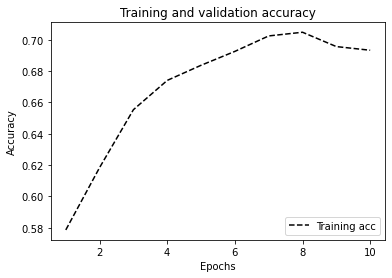

In [162]:
plt.plot(epochs, acc, 'k--', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [174]:
examples = [
  "The food was great!",
  "The service was okay.",
  "The nail salon was terrible...",
  "The food was good, the service was terrible, the decor was spectacular.",
  "Wow this thing is amazing!"
  ]

vector_examples = vectorize_layer(examples)

res = model.predict(vector_examples)

res

array([[  6.4441357],
       [-12.181259 ],
       [-13.588976 ],
       [-45.321297 ],
       [ 30.103067 ]], dtype=float32)